## 5.1 実験候補の生成

In [ ]:
# 5.1 実験候補の生成
import numpy as np
import polars as pl
from func import load_data

num_of_generating_samples = 10000  # 生成するサンプル数
desired_components_sum = 1  # 合計を指定する特徴量がある場合の、合計の値。例えば、この値を 100 にすれば、合計を 100 にできます

generation_settings = load_data("../test_data/setting_of_generation.csv").transpose(
    include_header=True, header_name="var", column_names=""
)
setting_items = generation_settings.columns[1:]  # varを除く設定項目名リスト
x_var_names = generation_settings.get_column("var")  # 特徴量名リスト
# 上、下限値を抽出
x_upper = generation_settings.get_column("upper").cast(pl.Float64)
x_lower = generation_settings.get_column("lower").cast(pl.Float64)
group_setting = generation_settings.get_column(
    "group with a total of desired_sum_of_components"
).cast(pl.Int64)
rounding = generation_settings.get_column("rounding").cast(pl.Int64)

# 0 から 1 の間の一様乱数でサンプル生成
rng = np.random.default_rng(99)
x_generated = pl.DataFrame(
    {
        col: rng.uniform(
            lower,
            upper,
            num_of_generating_samples,
        )
        for col, lower, upper in zip(x_var_names, x_lower, x_upper)
    }
)

# 合計を desired_components_sum にする特徴量がある場合
if sum(group_setting) != 0:
    var_groups = (
        pl.DataFrame({"vars": x_var_names, "group_no": group_setting})
        .group_by("group_no", maintain_order=True)
        .agg(pl.col("vars").implode())
    ).filter(pl.col("group_no") != 0)

    for grouped_vars in var_groups.get_column("vars"):
        x_generated = x_generated.with_columns(
            pl.col(grouped_vars)
            .truediv(pl.sum_horizontal(pl.col(grouped_vars)))
            .mul(desired_components_sum)
        )
    # 全変数が下限以上かつ上限未満である行のみ残す (各列ごとに [x_lower, x_upper) を満たすこと)
    mask = x_generated.select(
        [
            (pl.col(col) >= lower) & (pl.col(col) < upper)
            for col, lower, upper in zip(x_var_names, x_lower, x_upper)
        ]
    ).min_horizontal()
    x_generated = x_generated.filter(mask)

# 数値の丸め込みをする場合
if "rounding" in setting_items:
    x_generated = x_generated.with_columns(
        [
            pl.col(col)
            .mul(10**round_digit)
            .round(0, "half_away_from_zero")
            .truediv(10**round_digit)
            for col, round_digit in zip(x_var_names, rounding)
        ]
    )

# temperatureとtimeをint型に変換して、インデックスを追加してCSV出力
x_generated.with_columns(
    [
        pl.col("temperature").cast(pl.Int64),
        pl.col("time").cast(pl.Int64),
    ]
).with_row_index("").write_csv(
    "../output/05_01/generated_samples.csv", quote_style="never"
)


## 5.2 実験候補の選択

In [19]:
# 5.2 実験候補の選択

import numpy as np
import polars as pl
from func import autoscaling, load_data

# 選択するサンプル数
number_of_selecting_samples = 30
# ランダムにサンプルを選択して D 最適基準を計算する繰り返し回数
num_of_random_searches = 1000

idx_col_name = ""
x_generated, index = load_data(
    "../output/05_01/generated_samples.csv", index=idx_col_name
)
autoscaled_x_generated = autoscaling(x_generated)
# index列を後で使うので再結合
x_generated_wt_index = x_generated.insert_column(0, index)
autoscaled_x_generated_wt_index = autoscaled_x_generated.insert_column(0, index)

# 乱数シードを固定
seed = 11
# rng = np.random.default_rng(seed)
# pl.set_random_seed(seed)

# D 最適基準に基づくサンプル選択
best_d_optimal_value = float("-inf")  # 初期値を設定
for random_search_number in range(num_of_random_searches):
    # 1. ランダムに候補を選択
    temp_samples_wt_index = autoscaled_x_generated_wt_index.sample(
        n=number_of_selecting_samples, with_replacement=False, shuffle=False, seed=seed
    )
    temp_indexes = temp_samples_wt_index[idx_col_name]
    temp_samples_np = temp_samples_wt_index.drop(idx_col_name).to_numpy()

    # 2. D 最適基準を計算
    xt_x = np.dot(temp_samples_np.T, temp_samples_np)  # X'X を計算
    temp_d_optimal_value: np.float64 = np.linalg.det(xt_x)  # D 最適基準を計算

    # 3. D 最適基準が前回までの最大値を上回ったら、選択された候補を更新
    if temp_d_optimal_value > best_d_optimal_value:
        best_d_optimal_value = temp_d_optimal_value.copy()
        selected_indexes = temp_indexes.implode()
        selected_samples_wt_index = x_generated_wt_index.filter(
            pl.col(idx_col_name).is_in(selected_indexes)
        )

# 保存
selected_samples_wt_index.write_csv(
    "../output/05_02/selected_samples.csv", quote_style="never"
)

# 選択されなかったサンプル
remaining_samples_wt_index = x_generated_wt_index.filter(
    ~pl.col(idx_col_name).is_in(selected_indexes)
)
remaining_samples_wt_index.write_csv(
    "../output/05_02/remaining_samples.csv", quote_style="never"
)

print(selected_samples_wt_index.drop(idx_col_name).corr())  # 相関行列の確認

shape: (5, 5)
┌────────────────┬────────────────┬────────────────┬─────────────┬───────────┐
│ raw material 1 ┆ raw material 2 ┆ raw material 3 ┆ temperature ┆ time      │
│ ---            ┆ ---            ┆ ---            ┆ ---         ┆ ---       │
│ f64            ┆ f64            ┆ f64            ┆ f64         ┆ f64       │
╞════════════════╪════════════════╪════════════════╪═════════════╪═══════════╡
│ 1.0            ┆ -0.453874      ┆ -0.690676      ┆ 0.248368    ┆ 0.154256  │
│ -0.453874      ┆ 1.0            ┆ -0.330204      ┆ -0.058324   ┆ 0.057684  │
│ -0.690676      ┆ -0.330204      ┆ 1.0            ┆ -0.218392   ┆ -0.200395 │
│ 0.248368       ┆ -0.058324      ┆ -0.218392      ┆ 1.0         ┆ -0.174707 │
│ 0.154256       ┆ 0.057684       ┆ -0.200395      ┆ -0.174707   ┆ 1.0       │
└────────────────┴────────────────┴────────────────┴─────────────┴───────────┘


## 5.3 次の実験候補の選択

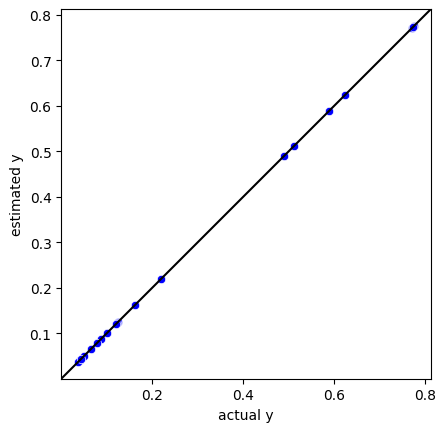

r^2 for training data : 0.9999999931263742
RMSE for training data : 2.2790784973808692e-05
MAE for training data : 1.7018909766406895e-05


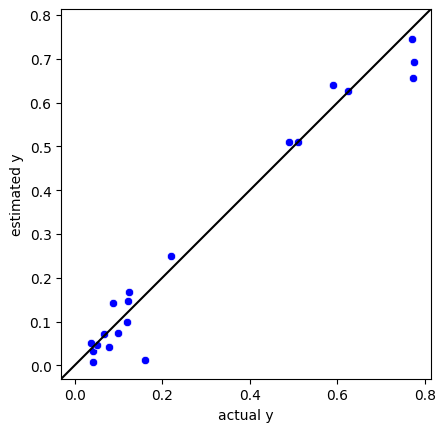

r^2 for training data : 0.9626474714375198
RMSE for training data : 0.05312835207520736
MAE for training data : 0.03772294067072186

トレーニングデータにおけるサポートベクター数 :10
トレーニングデータにおけるサポートベクターの割合 :0.5
トレーニングデータにおける外れサンプル数 :4
トレーニングデータにおける外れサンプルの割合 :0.2

予測用データセットにおける外れサンプル数 :4387 
予測用データセットにおける外れサンプルの割合 :0.451198189859097


In [23]:
# 5.3 次の実験候補の選択

import warnings

import polars as pl
from func import (
    add_sqrt_and_interaction_terms,
    autoscaling,
    calc_ad_by_knn,
    calc_ad_by_ocsvm,
    calc_optimal_gamma,
    calc_r2,
    delete_zero_std_columns,
    generate_kernels,
    load_data,
    optimize_hyperparameters_by_cv,
    optimize_hyperparameters_by_gs,
    rescaling,
    scatter_plot_of_result,
    show_fitting_evaluation,
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.svm import SVR, OneClassSVM

warnings.filterwarnings("ignore")

regression_method = "gpr_one_kernel"  # 回帰分析手法 'ols_linear', 'ols_nonlinear', 'svr_linear', 'svr_gaussian', 'gpr_one_kernel', 'gpr_kernels'
ad_method = "ocsvm"  # AD設定手法 'knn', 'ocsvm', 'ocsvm_gamma_optimization'

fold_number = 10  # クロスバリデーションの fold 数
# AD 内となるトレーニングデータの割合。AD　のしきい値を決めるときに使用
rate_of_training_samples_within_ad = 0.96

# 線形SVRのハイパーパラメータ
linear_svr_cs = 2.0 ** pl.arange(-10, 5, eager=True)  # C の候補
linear_svr_epsilons = 2.0 ** pl.arange(-10, 0, eager=True)  # ε の候補

# 非線形SVRのハイパーパラメータ
nonlinear_svr_cs = 2.0 ** pl.arange(-5, 10, eager=True)  # C の候補
nonlinear_svr_epsilons = 2.0 ** pl.arange(-10, 0, eager=True)  # ε の候補
nonlinear_svr_gammas = 2.0 ** pl.arange(-20, 10, eager=True)  # γ の候補
kernel_number = 2  # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10

# k-NN における k
k_in_knn = 5

# OCSVMのハイパーパラメータ
ocsvm_nu = 0.04  # OCSVM における ν。トレーニングデータにおけるサンプル数に対する、サポートベクターの数の下限の割合
ocsvm_gamma = 0.1  # OCSVM における γ
ocsvm_gammas = 2.0 ** pl.arange(-20, 11, eager=True)  # γ の候補

# トレーニングデータの読み込み
dataset_train, index_train = load_data("../test_data/resin.csv", index="")
# データ分割
y_train = dataset_train.get_column("property")  # 目的変数
x_train = dataset_train.drop(y_train.name)  # 説明変数
# 予測データの読み込み
dataset_pred, index_pred = load_data("../output/05_02/remaining_samples.csv", index="")
x_pred = dataset_pred.clone()

if regression_method == "ols_nonlinear":
    print("\n二乗項と交差項の追加")
    x_train = add_sqrt_and_interaction_terms(x_train)
    x_pred = add_sqrt_and_interaction_terms(x_pred)

# 標準偏差が 0 の特徴量の削除
x_train = delete_zero_std_columns(x_train)
x_pred = x_pred.select(x_train.columns)

# オートスケーリング
autoscaled_y_train = autoscaling(y_train)
autoscaled_x_train = autoscaling(x_train)
autoscaled_x_pred = autoscaling(x_pred, x_train)

# モデル構築
if regression_method == "ols_linear" or regression_method == "ols_nonlinear":
    model = LinearRegression()

elif regression_method == "svr_linear":
    # クロスバリデーションによる C, ε の最適化
    # クロスバリデーションの分割の設定
    cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
    # グリッドサーチの設定
    best_params = optimize_hyperparameters_by_gs(
        SVR(),
        autoscaled_x_train,
        autoscaled_y_train,
        param_grid={
            "C": linear_svr_cs.to_numpy(),
            "epsilon": linear_svr_epsilons.to_numpy(),
        },
        cv=cv,
        kernel="linear",
    )
    # SVRモデルの宣言
    model = SVR(kernel="linear", C=best_params["C"], epsilon=best_params["epsilon"])

elif regression_method == "svr_gaussian":
    # クロスバリデーションの分割の設定
    cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
    # C, ε, γの最適化
    optimal_nonlinear_c, optimal_nonlinear_epsilon, optimal_nonlinear_gamma = (
        optimize_hyperparameters_by_cv(
            SVR(),
            autoscaled_x_train,
            autoscaled_y_train,
            y_train,
            param_grid={
                "C": nonlinear_svr_cs.to_numpy(),
                "epsilon": nonlinear_svr_epsilons.to_numpy(),
                "gamma": nonlinear_svr_gammas.to_numpy(),
            },
            cv=cv,
            kernel="rbf",
        )
    )
    # モデル構築
    # SVR モデルの宣言
    model = SVR(
        kernel="rbf",
        C=optimal_nonlinear_c,
        epsilon=optimal_nonlinear_epsilon,
        gamma=optimal_nonlinear_gamma,
    )

elif regression_method == "gpr_one_kernel":
    # カーネル 11 種類
    kernels = generate_kernels(x_train)
    selected_kernel = kernels[kernel_number]
    model = GaussianProcessRegressor(alpha=0, kernel=selected_kernel, random_state=99)

elif regression_method == "gpr_kernels":
    # カーネル 11 種類
    kernels = generate_kernels(x_train)
    # クロスバリデーションによるカーネル関数の最適化
    # クロスバリデーションの分割の設定
    cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
    r2_cvs = pl.Series(
        "r2_cvs",
        [
            calc_r2(
                GaussianProcessRegressor,
                autoscaled_x_train,
                autoscaled_y_train,
                cv,
                y_train,
                kernel=kernel,
            )
            for kernel in kernels
        ],
    )
    optimal_kernel = kernels[r2_cvs.arg_max()]  # r2が最も大きい(最適な)カーネル関数
    print("クロスバリデーションで選択されたカーネル関数 :", optimal_kernel)

    # モデル構築
    model = GaussianProcessRegressor(
        alpha=0, kernel=optimal_kernel, random_state=99
    )  # GPR モデルの宣言

model.fit(autoscaled_x_train, autoscaled_y_train)  # モデル構築

# 標準回帰係数
if regression_method in ["ols_linear", "ols_nonlinear", "svr_linear"]:
    if regression_method == "svr_linear":
        coefs = model.coef_.T
    else:
        coefs = model.coef_

    pl.DataFrame(
        {
            "": x_train.columns,
            "standard_regression_coefficients": coefs.flatten(),
        }
    ).write_csv(
        f"../output/05_03/standard_regression_coefficients_{regression_method}.csv",
        quote_style="never",
    )

# トレーニングデータの推定
autoscaled_estimated_y = pl.Series(model.predict(autoscaled_x_train))
estimated_y = rescaling(autoscaled_estimated_y, y_train)

# トレーニングデータの実測値 vs. 推定値のプロット
scatter_plot_of_result(
    f"../output/05_03/actual_vs_estimated_y_train_{regression_method}.png",
    y_train,
    estimated_y,
    "actual y",
    "estimated y",
)

# トレーニングデータのr2, RMSE, MAE
show_fitting_evaluation(y_train, estimated_y)

# トレーニングデータの結果の保存
pl.DataFrame(
    {
        "": index_train,
        "actual_y": y_train,
        "estimated_y": estimated_y,
        "error_of_y(actual_y-estimated_y)": y_train - estimated_y,
    }
).write_csv(
    f"../output/05_03/estimated_y_in_detail_{regression_method}.csv",
    quote_style="never",
)

# クロスバリデーションによる y の値の推定
cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
autoscaled_estimated_y_in_cv = pl.Series(
    cross_val_predict(model, autoscaled_x_train, autoscaled_y_train, cv=cv)
)
estimated_y_in_cv = rescaling(autoscaled_estimated_y_in_cv, y_train)

# クロスバリデーションにおける実測値 vs. 推定値のプロット
scatter_plot_of_result(
    f"../output/05_03/actual_vs_estimated_y_in_cv_{regression_method}.png",
    y_train,
    estimated_y_in_cv,
    "actual y",
    "estimated y",
)

# クロスバリデーションにおけるr2, RMSE, MAE
show_fitting_evaluation(y_train, estimated_y_in_cv)

# クロスバリデーションの結果の保存
pl.DataFrame(
    {
        "": index_train,
        "actual_y": y_train,
        "estimated_y": estimated_y_in_cv,
        "error_of_y(actual_y-estimated_y)": y_train - estimated_y_in_cv,
    }
).write_csv(
    f"../output/05_03/estimated_y_in_cv_in_detail_{regression_method}.csv",
    quote_style="never",
)

# 予測
if regression_method in ["gpr_one_kernel", "gpr_kernels"]:
    estimated_y_pred, estimated_y_pred_std = model.predict(
        autoscaled_x_pred, return_std=True
    )
    # スケールを戻す
    estimated_y_pred = rescaling(pl.Series(estimated_y_pred), y_train)
    estimated_y_pred_std = rescaling(
        pl.Series(estimated_y_pred_std), y_train, is_std=True
    )
    # csv保存
    pl.DataFrame(
        {
            "": index_pred,
            "estimated_y": estimated_y_pred,
            "std_of_estimated_y": estimated_y_pred_std,
        }
    ).write_csv(f"../output/05_03/estimated_y_prediction_{regression_method}.csv")
else:
    estimated_y_pred = pl.Series("estimated_y", model.predict(x_pred))
    # csv保存
    pl.DataFrame({"": index_pred, "estimated_y": estimated_y_pred}).write_csv(
        f"../output/05_03/estimated_y_prediction_{regression_method}.csv"
    )

# ADの前処理(ols_nonlinearのみ)
if regression_method == "ols_nonlinear":
    # x_trainやx_predは非線形変換済みなので、AD前に元に戻してから処理する
    # この時点のx_train, x_predは、
    # 非線形変換や、std=0の特徴量を削除したデータなので、オリジナルを再取得
    x_train = dataset_train.drop(y_train.name)
    x_pred = dataset_pred.clone()

    # std=0 削除
    x_train = delete_zero_std_columns(x_train)
    x_pred = x_pred.select(x_train.columns)

    # オートスケーリング
    autoscaled_x_train = autoscaling(x_train)
    autoscaled_x_pred = autoscaling(x_pred, x_train)

# AD
if ad_method == "knn":
    mean_of_knn_distance_train, within_ad_flag_train, ad_threshold_train = (
        calc_ad_by_knn(
            autoscaled_x_train,
            n_neighbors=k_in_knn,
            ad_threshold=rate_of_training_samples_within_ad,
            remove_self=True,
        )
    )
    pl.DataFrame(
        {
            "": index_train,
            "mean_of_knn_distance": mean_of_knn_distance_train,
            "within_ad": within_ad_flag_train,
        }
    ).write_csv("../output/05_03/mean_of_knn_distance_train.csv", quote_style="never")

    # 予測用データに対して同様の処理を行う
    mean_of_knn_distance_pred, within_ad_flag_pred, ad_threshold_pred = calc_ad_by_knn(
        autoscaled_x_pred,
        n_neighbors=k_in_knn,
        ad_threshold=rate_of_training_samples_within_ad,
        remove_self=False,
    )
    pl.DataFrame(
        {
            "": index_pred,
            "mean_of_knn_distance": mean_of_knn_distance_pred,
            "within_ad": within_ad_flag_pred,
        }
    )
    ad_index_pred = mean_of_knn_distance_pred

elif ad_method == "ocsvm":
    if ad_method == "ocsvm_gamma_optimization":
        # グラム行列の分散が最大となるγを探索
        optimal_gamma = calc_optimal_gamma(autoscaled_x_train, ocsvm_gammas)
        print("最適化された gamma :", optimal_gamma)
    else:
        optimal_gamma = ocsvm_gamma

    # モデルを構築
    ad_model = OneClassSVM(kernel="rbf", gamma=optimal_gamma, nu=ocsvm_nu)
    ad_model.fit(autoscaled_x_train)

    # トレーニングデータを処理
    data_density_train, within_ad_flag_train = calc_ad_by_ocsvm(
        ad_model, autoscaled_x_train, train_data=True
    )
    pl.DataFrame(
        {
            "": index_train,
            "ocsvm_data_density": data_density_train,
            "within_ad_flag": within_ad_flag_train,
        }
    ).write_csv("../output/05_03/ocsvm_data_density_train.csv", quote_style="never")

    # 予測用データセットも同様に処理
    data_density_pred, within_ad_flag_pred = calc_ad_by_ocsvm(
        ad_model, autoscaled_x_pred, train_data=False
    )
    pl.DataFrame(
        {
            "": index_pred,
            "ocsvm_data_density": data_density_pred,
            "within_ad_flag": within_ad_flag_pred,
        }
    ).write_csv(
        "../output/05_03/ocsvm_data_density_prediction.csv", quote_style="never"
    )


# AD外の予測値をマスク
estimated_y_pred[~within_ad_flag_pred] = float("-inf")

# 保存
pl.DataFrame({"": index_pred, "ad_index_prediction": data_density_pred}).write_csv(
    f"../output/05_03/ad_index_prediction_{ad_method}.csv", quote_style="never"
)
pl.DataFrame({"": index_pred, "estimated_y": estimated_y_pred}).write_csv(
    f"../output/05_03/estimated_y_prediction_considering_ad_{regression_method}_{ad_method}.csv"
)

# 次のサンプル
next_sample = x_pred.insert_column(0, index_pred).slice(estimated_y_pred.arg_max(), 1)
next_sample.write_csv(
    f"../output/05_03/next_sample_{regression_method}_{ad_method}.csv"
)


## 5.4 ベイズ最適化

クロスバリデーションで選択されたカーネル関数 : 1**2 * RBF(length_scale=[1, 1, 1, 1, 1]) + WhiteKernel(noise_level=1)


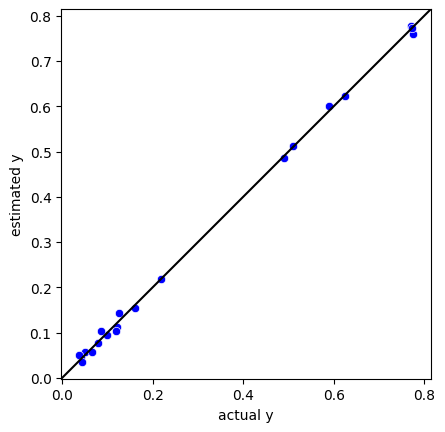

r^2 for training data : 0.9988181693679478
RMSE for training data : 0.009450264482144024
MAE for training data : 0.00772500983791673


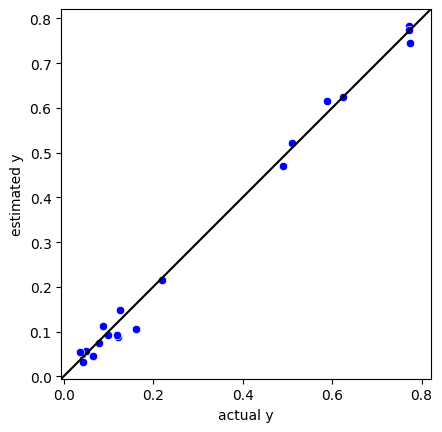

r^2 for training data : 0.9939168693662362
RMSE for training data : 0.02144025337713043
MAE for training data : 0.017085550708866443


In [ ]:
# 5.4 ベイズ最適化
import warnings

import polars as pl
from func import (
    autoscaling,
    calc_acquisition_func,
    calc_r2,
    delete_zero_std_columns,
    generate_kernels,
    load_data,
    rescaling,
    scatter_plot_of_result,
    show_fitting_evaluation,
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import KFold, cross_val_predict

warnings.filterwarnings("ignore")

regression_method = "gpr_one_kernel"  # 'gpr_one_kernel', 'gpr_kernels'
acquisition_function = "PTR"  # 'PTR', 'PI', 'EI', 'MI'

fold_number = 10  # クロスバリデーションの fold 数
kernel_number = 2  # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
target_range = [0, 1]  # PTR
relaxation = 0.01  # EI, PI
delta = 1e-6  # MI

# トレーニングデータの読み込み
dataset_train, index_train = load_data("../test_data/resin.csv", index="")
# データ分割
y_train = dataset_train.get_column("property")  # 目的変数
x_train = dataset_train.drop(y_train.name)  # 説明変数
# 予測データの読み込み
dataset_pred, index_pred = load_data("../output/05_02/remaining_samples.csv", index="")
x_pred = dataset_pred.clone()

# 標準偏差が 0 の特徴量の削除
x_train = delete_zero_std_columns(x_train)
x_pred = x_pred.select(x_train.columns)

# オートスケーリング
autoscaled_y_train = autoscaling(y_train)
autoscaled_x_train = autoscaling(x_train)
autoscaled_x_pred = autoscaling(x_pred, x_train)

# カーネル 11 種類
kernels = generate_kernels(x_train)

# モデル構築
if regression_method == "gpr_one_kernel":
    selected_kernel = kernels[kernel_number]
    model = GaussianProcessRegressor(alpha=0, kernel=selected_kernel, random_state=99)

elif regression_method == "gpr_kernels":
    # クロスバリデーションによるカーネル関数の最適化
    # クロスバリデーションの分割の設定
    cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
    r2_cvs = pl.Series(
        "r2_cvs",
        [
            calc_r2(
                GaussianProcessRegressor,
                autoscaled_x_train,
                autoscaled_y_train,
                cv,
                y_train,
                kernel=kernel,
                random_state=99,
            )
            for kernel in kernels
        ],
    )
    optimal_kernel = kernels[r2_cvs.arg_max()]  # r2が最も大きい(最適な)カーネル関数
    print("クロスバリデーションで選択されたカーネル関数 :", optimal_kernel)

    # モデル構築 GPR モデルの宣言
    model = GaussianProcessRegressor(alpha=0, kernel=optimal_kernel, random_state=99)

model.fit(autoscaled_x_train, autoscaled_y_train)  # モデル構築

# トレーニングデータの推定
autoscaled_estimated_y, autoscaled_estimated_y_std = model.predict(
    autoscaled_x_train, return_std=True
)
estimated_y = rescaling(pl.Series("estimated_y", autoscaled_estimated_y), y_train)
estimated_y_std = rescaling(
    pl.Series("std_of_estimated_y", autoscaled_estimated_y_std), y_train, is_std=True
)

# トレーニングデータの実測値 vs. 推定値のプロット
scatter_plot_of_result(
    f"../output/05_04/actual_vs_estimated_y_{regression_method}.png",
    y_train,
    estimated_y,
    "actual y",
    "estimated y",
)

# トレーニングデータのr2, RMSE, MAE
show_fitting_evaluation(y_train, estimated_y)

# トレーニングデータの結果の保存
pl.DataFrame(
    {
        "": index_train,
        "actual_y": y_train,
        "estimated_y": estimated_y,
        "error_of_y(actual_y-estimated_y)": y_train - estimated_y,
    }
).write_csv(
    f"../output/05_04/estimated_y_in_detail_{regression_method}.csv",
    quote_style="never",
)

# クロスバリデーションによる y の値の推定
cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
autoscaled_estimated_y_in_cv = pl.Series(
    cross_val_predict(model, autoscaled_x_train, autoscaled_y_train, cv=cv)
)
estimated_y_in_cv = rescaling(autoscaled_estimated_y_in_cv, y_train)

# クロスバリデーションにおける実測値 vs. 推定値のプロット
scatter_plot_of_result(
    f"../output/05_04/actual_vs_estimated_y_in_cv_{regression_method}.png",
    y_train,
    estimated_y_in_cv,
    "actual y",
    "estimated y",
)

# クロスバリデーションにおけるr2, RMSE, MAE
show_fitting_evaluation(y_train, estimated_y_in_cv)

# クロスバリデーションの結果の保存
pl.DataFrame(
    {
        "": index_train,
        "actual_y": y_train,
        "estimated_y": estimated_y_in_cv,
        "error_of_y(actual_y-estimated_y)": y_train - estimated_y_in_cv,
    }
).write_csv(
    f"../output/05_04/estimated_y_in_cv_in_detail_{regression_method}.csv",
    quote_style="never",
)

# 予測
estimated_y_pred, estimated_y_pred_std = model.predict(
    autoscaled_x_pred, return_std=True
)
# スケールを戻す
estimated_y_pred = rescaling(pl.Series(estimated_y_pred), y_train)
estimated_y_pred_std = rescaling(pl.Series(estimated_y_pred_std), y_train, is_std=True)

# csv保存
pl.DataFrame(
    {
        "": index_pred,
        "estimated_y": estimated_y_pred,
        "std_of_estimated_y": estimated_y_pred_std,
    }
).write_csv(f"../output/05_04/estimated_y_prediction_{regression_method}.csv")

# 獲得関数の計算
acquisition_function_prediction, _ = calc_acquisition_func(
    estimated_y_pred,
    estimated_y_pred_std,
    acquisition_function,
    target_range,
    relaxation,
    delta,
)

# csv保存
pl.DataFrame(
    {
        "": index_pred,
        "acquisition_function": acquisition_function_prediction,
        "std_of_estimated_y": estimated_y_pred_std,
    }
).write_csv(
    f"../output/05_04/acquisition_function_prediction_{regression_method}_{acquisition_function}.csv",
    quote_style="never",
)

# 次のサンプル
next_sample = x_pred.insert_column(0, index_pred).slice(
    acquisition_function_prediction.arg_max(), 1
)
next_sample.write_csv(
    f"../output/05_04/next_sample_{regression_method}_{acquisition_function}.csv"
)


## 5.4.1 ベイズ最適化による実験候補の選択

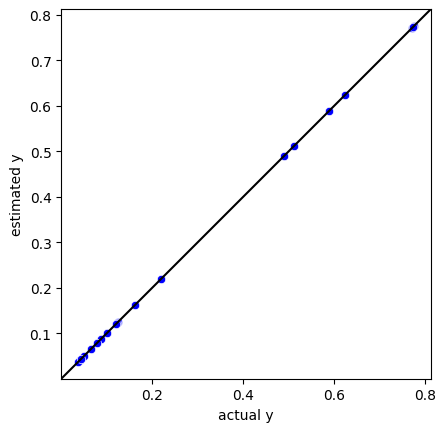

r^2 for training data : 0.9999999931263742
RMSE for training data : 2.279078497430688e-05
MAE for training data : 1.701890976674829e-05


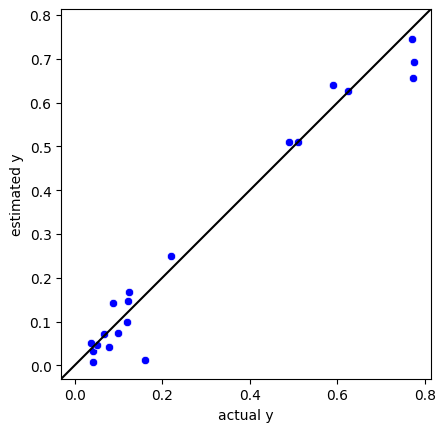

r^2 for training data : 0.9626474137742805
RMSE for training data : 0.053128393083832645
MAE for training data : 0.03772295471665506
sample number : 1 / 5
sample number : 2 / 5
sample number : 3 / 5
sample number : 4 / 5
sample number : 5 / 5


In [ ]:
# 5.4.1 ベイズ最適化による実験候補の選択

import warnings

import polars as pl
from func import (
    autoscaling,
    calc_acquisition_func,
    calc_r2,
    delete_zero_std_columns,
    generate_kernels,
    load_data,
    rescaling,
    scatter_plot_of_result,
    show_fitting_evaluation,
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import KFold, cross_val_predict

warnings.filterwarnings("ignore")

number_of_selecting_samples = 5  # 選択するサンプル数
regression_method = "gpr_one_kernel"  # gpr_one_kernel', 'gpr_kernels'
acquisition_function = "PTR"  # 'PTR', 'PI', 'EI', 'MI'

fold_number = 10  # クロスバリデーションの fold 数
kernel_number = 2  # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
target_range = [0, 1]  # PTR
relaxation = 0.01  # EI, PI
delta = 1e-6  # MI

# トレーニングデータの読み込み
dataset_train, index_train = load_data("../test_data/resin.csv", index="")
# データ分割
y_train = dataset_train.get_column("property")  # 目的変数
x_train = dataset_train.drop(y_train.name)  # 説明変数
# 予測データの読み込み
dataset_pred, index_pred = load_data("../output/05_02/remaining_samples.csv", index="")
x_pred = dataset_pred.clone()

# 標準偏差が 0 の特徴量の削除
x_train = delete_zero_std_columns(x_train)
x_pred = x_pred.select(x_train.columns)
# インデックスを結合(後で使用するため)
x_pred_wt_idx = x_pred.clone().insert_column(0, index_pred)

# カーネル 11 種類
kernels = generate_kernels(x_train)

# Bayesian optimization
# 次のサンプルを入れる変数を準備
next_samples = pl.DataFrame(schema=x_pred_wt_idx.schema)
for sample_number in range(number_of_selecting_samples):
    # オートスケーリング
    autoscaled_y_train = autoscaling(y_train)
    autoscaled_x_train = autoscaling(x_train)
    autoscaled_x_pred = autoscaling(x_pred, x_train)

    # モデル構築
    if regression_method == "gpr_one_kernel":
        selected_kernel = kernels[kernel_number]
        model = GaussianProcessRegressor(
            alpha=0, kernel=selected_kernel, random_state=99
        )

    elif regression_method == "gpr_kernels":
        # クロスバリデーションによるカーネル関数の最適化
        # クロスバリデーションの分割の設定
        cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
        r2_cvs = pl.Series(
            "r2_cvs",
            [
                calc_r2(
                    GaussianProcessRegressor,
                    autoscaled_x_train,
                    autoscaled_y_train,
                    cv,
                    y_train,
                    kernel=kernel,
                    random_state=99,
                )
                for kernel in kernels
            ],
        )
        optimal_kernel = kernels[r2_cvs.arg_max()]  # r2が最も大きい(最適な)カーネル関数
        print("クロスバリデーションで選択されたカーネル関数 :", optimal_kernel)

        # モデル構築 GPR モデルの宣言
        model = GaussianProcessRegressor(
            alpha=0, kernel=optimal_kernel, random_state=99
        )

    model.fit(autoscaled_x_train, autoscaled_y_train)  # モデル構築

    if sample_number == 0:
        # トレーニングデータの推定
        autoscaled_estimated_y, autoscaled_estimated_y_std = model.predict(
            autoscaled_x_train, return_std=True
        )
        estimated_y = rescaling(
            pl.Series("estimated_y", autoscaled_estimated_y), y_train
        )
        estimated_y_std = rescaling(
            pl.Series("std_of_estimated_y", autoscaled_estimated_y_std),
            y_train,
            is_std=True,
        )

        # トレーニングデータの実測値 vs. 推定値のプロット
        scatter_plot_of_result(
            f"../output/05_04/multi_sample_actual_vs_estimated_y_{regression_method}.png",
            y_train,
            estimated_y,
            "actual y",
            "estimated y",
        )

        # トレーニングデータのr2, RMSE, MAE
        show_fitting_evaluation(y_train, estimated_y)

        # トレーニングデータの結果の保存
        pl.DataFrame(
            {
                "": index_train,
                "actual_y": y_train,
                "estimated_y": estimated_y,
                "error_of_y(actual_y-estimated_y)": y_train - estimated_y,
                "std_of_estimated_y": estimated_y_std,
            }
        ).write_csv(
            f"../output/05_04/multi_sample_estimated_y_in_detail_{regression_method}.csv",
            quote_style="never",
        )

        # クロスバリデーションによる y の値の推定
        cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
        autoscaled_estimated_y_in_cv = pl.Series(
            cross_val_predict(model, autoscaled_x_train, autoscaled_y_train, cv=cv)
        )
        estimated_y_in_cv = rescaling(autoscaled_estimated_y_in_cv, y_train)

        # クロスバリデーションにおける実測値 vs. 推定値のプロット
        scatter_plot_of_result(
            f"../output/05_04/multi_sample_actual_vs_estimated_y_in_cv_{regression_method}.png",
            y_train,
            estimated_y_in_cv,
            "actual y",
            "estimated y",
        )

        # クロスバリデーションにおけるr2, RMSE, MAE
        show_fitting_evaluation(y_train, estimated_y_in_cv)

        # クロスバリデーションの結果の保存
        pl.DataFrame(
            {
                "": index_train,
                "actual_y": y_train,
                "estimated_y": estimated_y_in_cv,
                "error_of_y(actual_y-estimated_y)": y_train - estimated_y_in_cv,
            }
        ).write_csv(
            f"../output/05_04/multi_sample_estimated_y_in_cv_in_detail_{regression_method}.csv",
            quote_style="never",
        )

    # 予測
    estimated_y_pred, estimated_y_pred_std = model.predict(
        autoscaled_x_pred, return_std=True
    )
    # スケールを戻す
    estimated_y_pred = rescaling(pl.Series(estimated_y_pred), y_train)
    estimated_y_pred_std = rescaling(
        pl.Series(estimated_y_pred_std), y_train, is_std=True
    )

    # 獲得関数の計算
    acquisition_function_prediction, cumulative_variance = calc_acquisition_func(
        estimated_y_pred,
        estimated_y_pred_std,
        acquisition_function,
        target_range,
        relaxation,
        delta,
    )

    # csv保存
    if sample_number == 0:
        pl.DataFrame(
            {
                "": index_pred,
                "estimated_y": estimated_y_pred,
                "std_of_estimated_y": estimated_y_pred_std,
            }
        ).write_csv(
            f"../output/05_04/multi_sample_estimated_y_prediction_{regression_method}.csv"
        )
        pl.DataFrame(
            {
                "": index_pred,
                "acquisition_function": acquisition_function_prediction,
            }
        ).write_csv(
            f"../output/05_04/multi_sample_acquisition_function_prediction_{regression_method}_{acquisition_function}.csv",
            quote_style="never",
        )

    # 獲得関数から選択されたサンプルのインデックス
    next_id = acquisition_function_prediction.arg_max()
    # 次のサンプル
    next_sample = x_pred_wt_idx.slice(next_id, 1)
    next_index = next_sample.item(0, index_pred.name)
    next_samples = next_samples.vstack(next_sample)

    next_y = estimated_y_pred.clone().slice(next_id, 1)

    # x, y, x_prediction, cumulative_variance の更新
    x_train = x_train.vstack(next_sample.drop(index_pred.name))
    y_train = y_train.append(next_y)
    x_pred_wt_idx = x_pred_wt_idx.filter(~pl.col(index_pred.name).is_in([next_index]))
    index_pred = x_pred_wt_idx[index_pred.name]
    x_pred = x_pred_wt_idx.drop(index_pred.name)
    mask = ~pl.Series(range(len(cumulative_variance))).is_in([next_id])
    cumulative_variance = cumulative_variance.filter(mask)
    print(f"sample number : {sample_number + 1} / {number_of_selecting_samples}")


next_samples.write_csv(
    f"../output/05_04/multi_sample_next_samples_bo_{regression_method}_{acquisition_function}.csv"
)


## 5.4.2 目的変数が複数ある場合

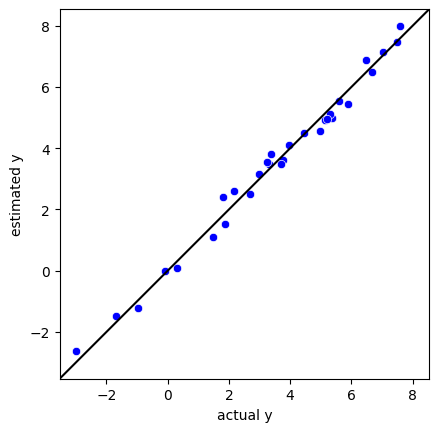

r^2 for training data : 0.9882778732200865
RMSE for training data : 0.2890448348249069
MAE for training data : 0.2525841296818685


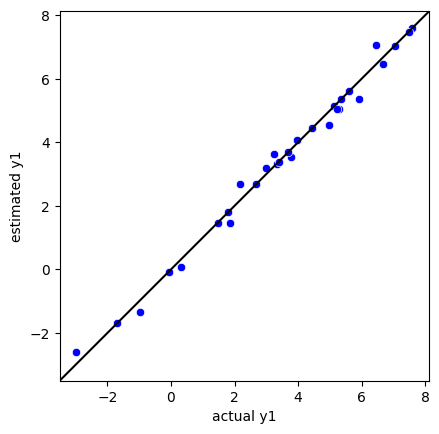

r^2 for training data : 0.9905900235128929
RMSE for training data : 0.2589740657763206
MAE for training data : 0.16883695796595422


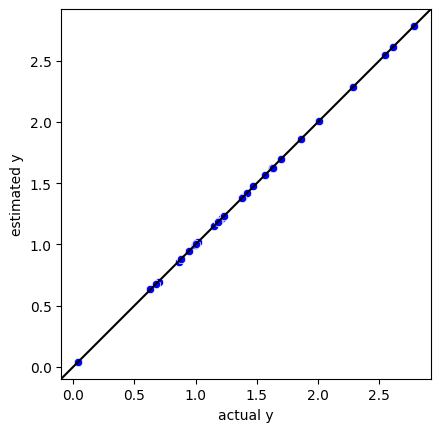

r^2 for training data : 0.9999828047597327
RMSE for training data : 0.002549452347370697
MAE for training data : 0.0018634948245206666


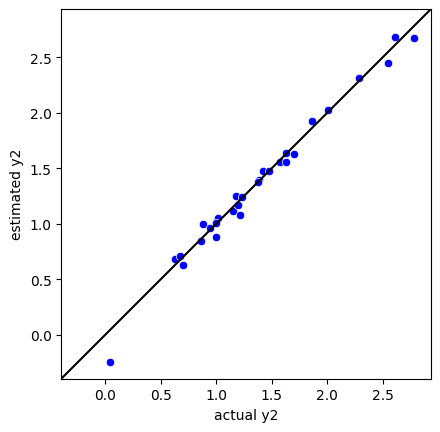

r^2 for training data : 0.9829682399855142
RMSE for training data : 0.08023660402422791
MAE for training data : 0.05683673725880419


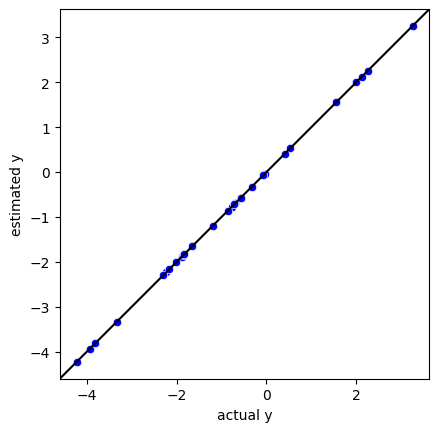

r^2 for training data : 0.9999999291397439
RMSE for training data : 0.0005018762089199569
MAE for training data : 0.00028251332812441324


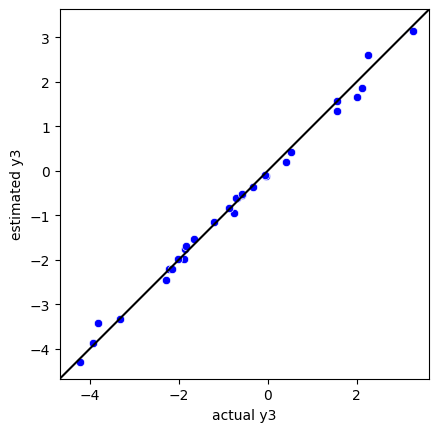

r^2 for training data : 0.993193900379262
RMSE for training data : 0.15554082593239954
MAE for training data : 0.11649641794823715


In [ ]:
# 5.4.2 目的変数が複数ある場合

from scipy.stats import norm
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.gaussian_process import GaussianProcessRegressor
import warnings

import polars as pl
from func import (
    autoscaling,
    calc_r2,
    delete_zero_std_columns,
    generate_kernels,
    load_data,
    rescaling,
    scatter_plot_of_result,
    show_fitting_evaluation,
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import KFold, cross_val_predict

warnings.filterwarnings("ignore")

regression_method = "gpr_one_kernel"  # gpr_one_kernel', 'gpr_kernels'

fold_number = 10  # クロスバリデーションの fold 数
kernel_number = 2  # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
relaxation = 0.01  # PI

dataset_train, index_train = load_data(
    "../test_data/training_data_multi_y.csv", index=""
)
x_pred, index_pred = load_data("../test_data/x_for_prediction_multi_y.csv", index="")
settings, setting_items = load_data(
    "../test_data/settings_in_bayesian_optimization_multi_y.csv", index=""
)
max_min_range_index = setting_items.index_of(
    "maximization(1)_or_minimization(-1)_or_range(0)"
)
ll_index = setting_items.index_of("lower_limit")
ul_index = setting_items.index_of("upper_limit")

# check datasets and settings
if not settings.width == (dataset_train.width - x_pred.width):
    raise Exception(
        "Check the numbers of y-variables and X-variables in training_data.csv, data_for_prediction.csv and settings.csv."
    )
for y_col in settings.iter_columns():
    if y_col.item(max_min_range_index) == 0 and (
        y_col.item(ll_index) >= y_col.item(ul_index)
    ):
        raise Exception(
            "`lower_limit` must be lower than `upper_limit` in settings.csv."
        )

# データ分割
y_train = dataset_train.select(settings.columns)  # 目的変数
x_train = dataset_train.drop(y_train.columns)  # 説明変数

# 標準偏差が 0 の特徴量の削除
x_train = delete_zero_std_columns(x_train)
x_pred = x_pred.select(x_train.columns)

# カーネル 11 種類
kernels = generate_kernels(x_train)

# オートスケーリング
# オートスケーリング
autoscaled_y_train = autoscaling(y_train)
autoscaled_x_train = autoscaling(x_train)
autoscaled_x_pred = autoscaling(x_pred, x_train)
mean_of_y_train = y_train.mean()
std_of_y_train = y_train.std()

# Y ごとのモデル構築、予測
# Y の予測値を入れる変数
estimated_y_pred_all = pl.DataFrame({"": index_pred})
# Y の予測値の標準偏差を入れる変数
std_of_estimated_y_pred_all = pl.DataFrame({"": index_pred})
# Y の目標達成確率を入れる変数
probabilities_pred_all = pl.DataFrame({"": index_pred})
for target_autoscaled_y_train in autoscaled_y_train.iter_columns():
    # モデル構築
    if regression_method == "gpr_one_kernel":
        selected_kernel = kernels[kernel_number]
        model = GaussianProcessRegressor(
            alpha=0, kernel=selected_kernel, random_state=99
        )
    elif regression_method == "gpr_kernels":
        # クロスバリデーションによるカーネル関数の最適化
        # クロスバリデーションの分割の設定
        cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
        r2_cvs = pl.Series(
            "r2_cvs",
            [
                calc_r2(
                    GaussianProcessRegressor,
                    autoscaled_x_train,
                    target_autoscaled_y_train,
                    cv,
                    y_train,
                    kernel=kernel,
                    random_state=99,
                )
                for kernel in kernels
            ],
        )
        optimal_kernel = kernels[r2_cvs.arg_max()]  # r2が最も大きい(最適な)カーネル関数
        print("クロスバリデーションで選択されたカーネル関数 :", optimal_kernel)

        # モデル構築
        # GPR モデルの宣言
        model = GaussianProcessRegressor(alpha=0, kernel=optimal_kernel)

    model.fit(autoscaled_x_train, target_autoscaled_y_train)  # モデル構築

    # トレーニングデータの推定
    # y の推定
    autoscaled_estimated_y, autoscaled_estimated_y_std = model.predict(
        autoscaled_x_train, return_std=True
    )
    target_y_train = y_train.get_column(target_autoscaled_y_train.name)
    # スケールをもとに戻す
    estimated_y = rescaling(
        pl.Series("estimated_y", autoscaled_estimated_y), target_y_train
    )
    estimated_y_std = rescaling(
        pl.Series("std_of_estimated_y", autoscaled_estimated_y_std),
        target_y_train,
        is_std=True,
    )

    # トレーニングデータの実測値 vs. 推定値のプロット
    scatter_plot_of_result(
        f"../output/05_04/multi_y_actual_vs_estimated_{regression_method}_{target_y_train.name}.png",
        target_y_train,
        estimated_y,
        "actual y",
        "estimated y",
    )

    # トレーニングデータのr2, RMSE, MAE
    show_fitting_evaluation(target_y_train, estimated_y)

    # トレーニングデータの結果の保存
    pl.DataFrame(
        {
            "": index_train,
            "actual_y": target_y_train,
            "estimated_y": estimated_y,
            "error_of_y(actual_y-estimated_y)": target_y_train - estimated_y,
        }
    ).write_csv(
        f"../output/05_04/multi_y_estimated_y_in_detail_{regression_method}_{target_y_train.name}.csv"
    )

    # クロスバリデーションによる y の値の推定
    # クロスバリデーションの分割の設定
    cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)

    # yの推定
    autoscaled_estimated_y_in_cv = cross_val_predict(
        model,
        autoscaled_x_train,
        autoscaled_y_train.get_column(target_y_train.name),
        cv=cv,
    )
    # スケールをもとに戻す
    estimated_y_in_cv = rescaling(
        pl.Series("estimated_y", autoscaled_estimated_y_in_cv),
        y_train.get_column(target_y_train.name),
    )

    # クロスバリデーションにおける実測値 vs. 推定値のプロット
    scatter_plot_of_result(
        f"../output/05_04/multi_y_actual_vs_estimated_in_cv_{regression_method}_{target_y_train.name}.png",
        target_y_train,
        estimated_y_in_cv,
        f"actual {target_y_train.name}",
        f"estimated {target_y_train.name}",
    )

    # クロスバリデーションにおけるr2, RMSE, MAE
    show_fitting_evaluation(target_y_train, estimated_y_in_cv)

    # クロスバリデーションの結果の保存
    pl.DataFrame(
        {
            "": index_train,
            "actual_y": target_y_train,
            "error_of_y(actual_y-estimated_y)": target_y_train - estimated_y_in_cv,
        }
    ).write_csv(
        f"../output/05_04/multi_y_estimated_y_in_cv_in_detail_{regression_method}_{target_y_train.name}.csv"
    )

    # 予測
    estimated_y_pred, estimated_y_pred_std = model.predict(
        autoscaled_x_pred, return_std=True
    )
    estimated_y_pred = rescaling(
        pl.Series("estimated_y", estimated_y_pred), target_y_train
    )
    estimated_y_pred_std = rescaling(
        pl.Series("std_of_estimated_y", estimated_y_pred_std),
        target_y_train,
        is_std=True,
    )

    # 獲得関数 (目標達成確率) の計算
    mode = settings.item(max_min_range_index, target_y_train.name)
    if mode == 1:
        probabilities_prediction = 1 - norm.cdf(
            target_y_train.max() + target_y_train.std() * relaxation,
            loc=estimated_y_pred,
            scale=estimated_y_pred_std,
        )
    elif mode == -1:
        probabilities_prediction = norm.cdf(
            target_y_train.min() - target_y_train.std() * relaxation,
            loc=estimated_y_pred,
            scale=estimated_y_pred_std,
        )

    elif mode == 0:
        probabilities_prediction = norm.cdf(
            settings.item(ul_index, target_y_train.name),
            loc=estimated_y_pred,
            scale=estimated_y_pred_std,
        ) - norm.cdf(
            settings.item(ll_index, target_y_train.name),
            loc=estimated_y_pred,
            scale=estimated_y_pred_std,
        )
    probabilities_prediction[estimated_y_pred_std <= 0] = 0

    # 格納
    # Y の予測値
    estimated_y_pred_all.with_columns(pl.Series(target_y_train.name, estimated_y_pred))
    # Y の予測値の標準偏差
    std_of_estimated_y_pred_all.with_columns(
        pl.Series(target_y_train.name, estimated_y_pred_std)
    )
    # Y の目標達成確率
    probabilities_pred_all.with_columns(
        pl.Series(target_y_train.name, probabilities_prediction)
    )


# 目標達成確率の対数の和
sum_of_log_prob = probabilities_pred_all.with_columns(pl.all().log()).sum_horizontal()
# sum_of_log_probabilities.replace()

# 保存
# 予測結果を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
estimated_y_pred_all.write_csv(
    f"../output/05_04/estimated_y_prediction_multi_y_{regression_method}.csv",
    quote_style="never",
)
# 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
std_of_estimated_y_pred_all.write_csv(
    f"../output/05_04/estimated_y_prediction_multi_y_std_{regression_method}.csv",
    quote_style="never",
)

# 獲得関数 (目標達成確率) を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
probabilities_pred_all.write_csv(
    f"../output/05_04/probabilities_prediction_multi_y_{regression_method}.csv",
    quote_style="never",
)
pl.DataFrame(
    {"": index_pred, "sum_of_log_probabilities": sum_of_log_prob},
).write_csv(
    f"../output/05_04/sum_of_log_probabilities_prediction_multi_y_{regression_method}.csv",
    quote_style="never",
)

# 次のサンプル
x_pred.slice(sum_of_log_prob.arg_max(), 1).write_csv(
    f"../output/05_04/next_sample_bo_multi_y_{regression_method}.csv"
)


## 5.4.3 目的変数が複数あり、複数のサンプルを選択する場合